In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from pathlib import Path
from enum import IntEnum
from heapq import *

In [2]:
class Environment(IntEnum):
    FLATLAND = 0 # unexplored grid we can go to
    POND = 1
    MOUNTAIN = 2
    OBSTACLE = 3
    EXPANDED = 4 # flatland that has been explored

def highlight_start_and_end(grid, cell, val):
    c_x, c_y = cell
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if np.sqrt((x - c_x) ** 2 + (y - c_y) ** 2) < 5: # this just verfies distance
                grid[int(x), int(y)] = val
    return grid


def visualize_grid_world(grid):
    _, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
    ])

    ax.imshow(grid_world, cmap=cmap)
    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"), # study what a Patch
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        ]

    ax.set_title(f"Grid World Visualization")
    ax.legend(handles=legend_elements,
              loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


def visualize_path(grid, start, goal, path):
    fig, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
        "#00AA00",  # Start & Goal
    ])

    grid_world = highlight_start_and_end(grid_world, start, len(cmap.colors) - 1)
    grid_world = highlight_start_and_end(grid_world, goal, len(cmap.colors) - 1)

    ax.imshow(grid_world, cmap=cmap)

    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"),
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        Patch(facecolor="#86592d", label="Expanded"),
        ]

    path_line, = ax.plot([], [], color='#FF0000', label='Path')

    if path:
        path_x, path_y = zip(*path)
        gw, = ax.plot(path_y, path_x, color='#FF0000', label='Path')
        legend_elements.append(Patch(facecolor='#FF0000', label='Path'))

    ax.set_title(f"Grid World Path Planning Result")
    ax.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 0),
        ncol=3
        )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


def visualize_expanded(grid, start, goal, expanded, path):
    fig, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
        "#86592d",  # Expanded
        "#00AA00",  # Start & Goal
    ])

    grid_world = highlight_start_and_end(grid_world, start, len(cmap.colors) - 1)
    grid_world = highlight_start_and_end(grid_world, goal, len(cmap.colors) - 1)

    if path:
        path_x, path_y = zip(*path)
        gw, = ax.plot(path_y, path_x, color='#FF0000', label='Path')

    # dumb bug fix
    fix_bug = grid_world[0, -1]
    grid_world[0, 3] = 4
    gw = ax.imshow(grid_world, cmap=cmap)
    grid_world[0, 3] = fix_bug

    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"),
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        Patch(facecolor="#86592d", label="Expanded"),
        Patch(facecolor='#FF0000', label='Path')
        ]

    expanded = [s for s in expanded if len(s) > 0]
    all_x, all_y = [], []

    for s in expanded:
        x, y = s
        all_x.append(x)
        all_y.append(y)
    grid_world[all_x, all_y] = Environment.EXPANDED
    gw.set_array(grid_world)

    ax.set_title(f"Grid World Expanded Cells Result")
    ax.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 0),
        ncol=3
        )

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


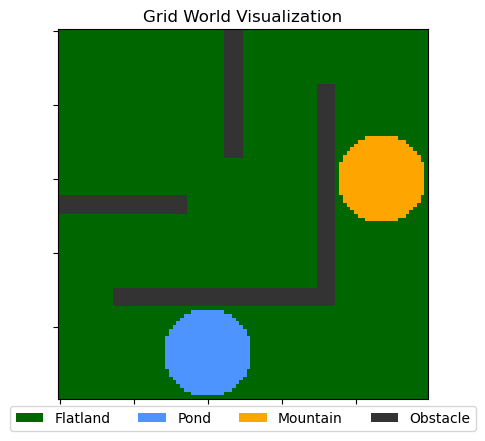

In [3]:
grid = np.load(f"./LPA_Worlds/world_1.npy")
visualize_grid_world(grid)

In [4]:
class LPA_Planner():
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.start = start
        self.goal = goal

        self.gridv = np.inf*np.ones((self.grid.shape[0], self.grid.shape[1]))
        self.gridg = np.inf*np.ones((self.grid.shape[0], self.grid.shape[1]))
        self.gridg[self.start] = 0

        self.gridh = np.ones((self.grid.shape[0], self.grid.shape[1]))
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                self.gridh[i,j] = 0.5 * ((self.goal[0]-i)**2 + (self.goal[1]-j)**2)**0.5
            #What is the point of scaling by 0.5 the distance
            #Our heuristic here is the Euclidean distance

        self.open_list = [(self.key(self.start), self.start)]
        heapify(self.open_list) # used to be a list but now is a heap
        self.parents = {self.start: None}
        #The LPA planner has a list of open nodes
    def key(self, node):
        return (min(self.gridv[node], self.gridg[node]) + self.gridh[node],
                min(self.gridv[node], self.gridg[node]))
    def cost(self, node):
        if self.grid[node] == Environment.FLATLAND:
            return 1
        elif self.grid[node] == Environment.POND:
            return 0.5
        elif self.grid[node] == Environment.MOUNTAIN:
            return 2
        elif self.grid[node] == Environment.OBSTACLE:
            return np.inf
    def neighbors(self, node):
        neighbors = []
        adjacent = [[0, 1], [1, 0], [0, -1], [-1, 0],
                    [1, 1], [1, -1], [-1, 1], [-1, -1]]
        x, y = node
        for i, j in adjacent:
            if x + i >= 0 and x + i < self.grid.shape[0] and \
               y + j >= 0 and y + j < self.grid.shape[1] and \
               self.grid[x + i, y + j] != Environment.OBSTACLE:
                neighbors.append((x + i, y + j))
        return neighbors

    def update_costs(self, rows, cols, feature):
        self.grid[rows, cols] = feature
        for i in range(len(rows)):
            self.update_node((rows[i], cols[i]))


    def update_node(self, node):
        # TODO
        # adding a distnace functions seems redundant but check the grids

        def edist(node, neighbor):
            return np.sqrt((node[0] - neighbor[0])**2 + (node[1] - neighbor[1])**2)
        vp = self.neighbors(node)
        if vp is not None:
            for i in range(0,len(vp)):
                #print(dist(vp[i], node))
                #edist could have been used but why not manhattan dist
                #d = np.sqrt(abs(node[0] - vp[i][0]) + abs(node[1] - vp[i][1]))
                #print(d == edist(vp[i], node))
                #print(edist(vp[i], node))
                tmp = self.gridv[vp[i]] + edist(vp[i], node) * self.cost(node)
                #print(tmp)
                if tmp < self.gridg[node]:
                    self.gridg[node] = tmp
                    self.parents[node] = vp[i]

        #idx = 1
        for i in range(len(self.open_list)):
            #print(len(self.open_list))
            if self.open_list[i][1] == node:
                #idx = -1
                if self.key(node) != self.open_list[i][0]:
                    self.open_list.remove(self.open_list[i])
                    heapify(self.open_list)
                    break
                return # maybe remove this break
        if self.gridg[node] != self.gridv[node]:
            heappush(self.open_list, (self.key(node), node))
            heapify(self.open_list)
        """
            if self.gridg[node] != self.gridv[node] and idx == -1:
                #print("neg index")
                self.open_list.append((self.key(node), node))
                heapify(self.open_list)

            elif idx != -1:
                self.open_list.remove(tmpN)
                heapify(self.open_list)
        """
    def compute_path(self):
        # TODO
        expanded = []
        path = [self.goal]
        #print(len(self.open_list))
        while(self.open_list[0][0] < self.key(self.goal) or self.gridv[self.goal] != self.gridg[self.goal]):
            key, curr = heappop(self.open_list)
            if self.gridv[curr] > self.gridg[curr]:
                self.gridv[curr] = self.gridg[curr]
            else:
                self.gridv[curr] = np.inf
                self.update_node(curr)
            varNeighbors = self.neighbors(curr)
            for n in varNeighbors:
                if n is not self.start:
                    #if n not in self.parents.keys():
                        #self.parents[n] = [curr]
                    #elif self.parents[n] is not None and curr not self.parents:
                        #self.parents[n].append()
                    self.update_node(n)
            expanded.append(curr)
        pptr = self.parents[self.goal]
        #print(pptr)
        #print(path)
        while pptr != None:
            #print(path)
            path.append(pptr)
            pptr = self.parents[pptr]
        return path[::-1], expanded


In [5]:
def main(searcher):
    path, expanded = searcher.compute_path()
    path_cost = 0
    for i in range(1,len(path)):
        d = 1 if path[i][0] == path[i-1][0] or path[i][1] == path[i-1][1] else np.sqrt(2)
        path_cost += d*searcher.cost(path[i])

    print(f"Path length: {len(path)}")
    print(f"Path cost: {path_cost}")
    print(f"Number of expanded states: {len(expanded)}")
    visualize_path(searcher.grid, searcher.start, searcher.goal, path)
    visualize_expanded(searcher.grid, searcher.start, searcher.goal, expanded, path)

# **World 1**

Initial planning...
Path length: 141
Path cost: 152.52438661763946
Number of expanded states: 8231


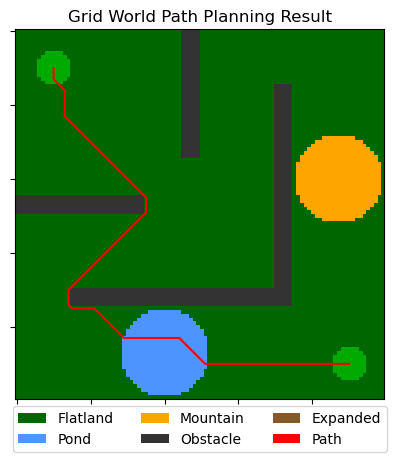

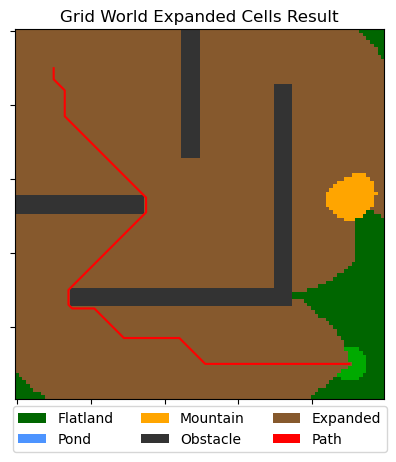

In [6]:
grid = np.load(f"./LPA_Worlds/world_1.npy")
start = (10, 10)
goal = (90, 90)
searcher = LPA_Planner(grid, start, goal)
print("Initial planning...")
main(searcher)

Initial planning...
Path length: 136
Path cost: 146.6604255869605
Number of expanded states: 7948


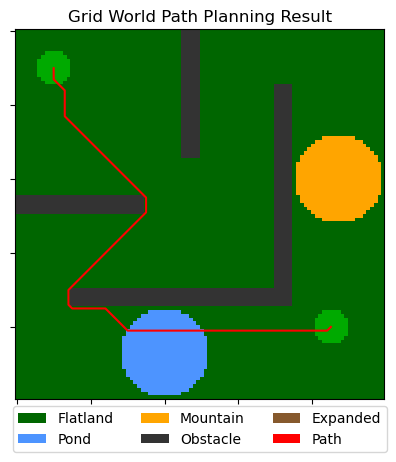

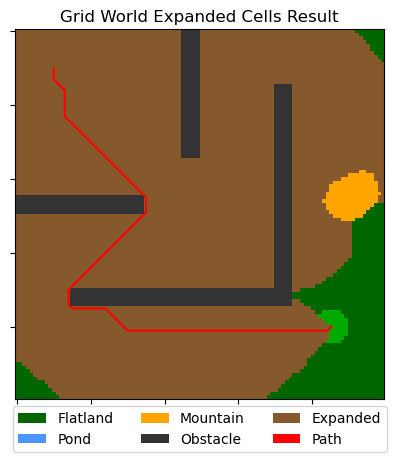

In [7]:
grid = np.load(f"./LPA_Worlds/world_1.npy")
start = (10, 10)
goal = (80, 85)
searcher = LPA_Planner(grid, start, goal)
print("Initial planning...")
main(searcher)

Initial planning...
Path length: 136
Path cost: 149.1812408671319
Number of expanded states: 8180


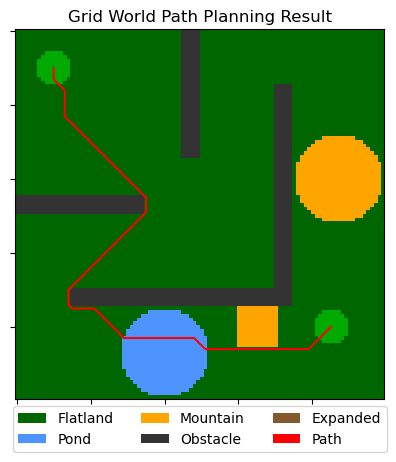

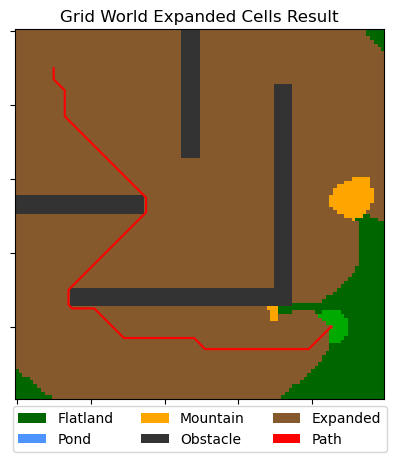

In [8]:
grid = np.load(f"./LPA_Worlds/world_1.npy")
start = (10, 10)
goal = (80, 85)
searcher = LPA_Planner(grid, start, goal)
rows, cols = np.meshgrid(np.arange(75, 86, 1), np.arange(60, 71, 1))
#print(rows)
searcher.update_costs(rows.flatten(), cols.flatten(), Environment.MOUNTAIN)
print("Initial planning...")
main(searcher)

Initial planning...
Path length: 132
Path cost: 146.4177848998412
Number of expanded states: 8339


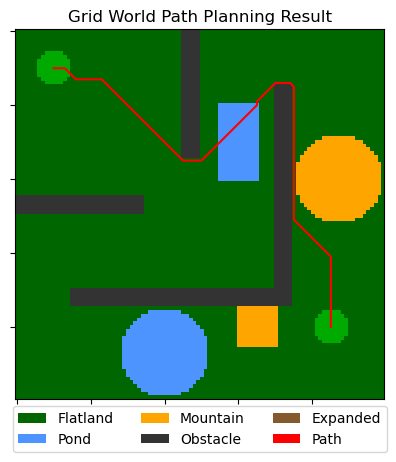

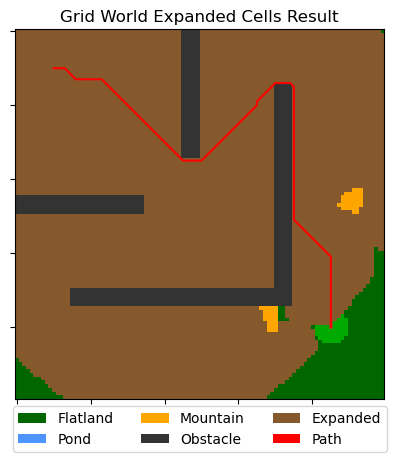

In [9]:
grid = np.load(f"./LPA_Worlds/world_1.npy")
start = (10, 10)
goal = (80, 85)
searcher = LPA_Planner(grid, start, goal)
rows1, cols1 = np.meshgrid(np.arange(75, 86, 1), np.arange(60, 71, 1))
rows2, cols2 = np.meshgrid(np.arange(20, 41, 1), np.arange(55, 66, 1))
searcher.update_costs(rows1.flatten(), cols1.flatten(), Environment.MOUNTAIN)
searcher.update_costs(rows2.flatten(), cols2.flatten(), Environment.POND)
print("Initial planning...")
main(searcher)

# **World 2**

Initial planning...
Path length: 111
Path cost: 96.70458146424491
Number of expanded states: 7229


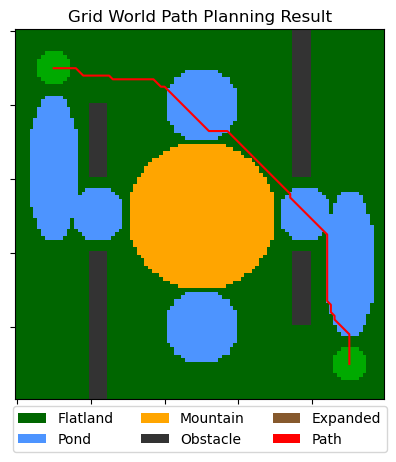

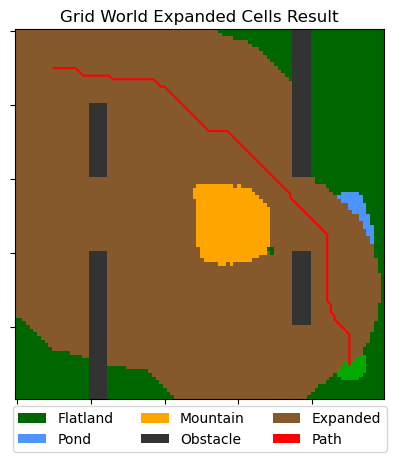

In [10]:
grid = np.load(f"./LPA_Worlds/world_2.npy")
start = (10, 10)
goal = (90, 90)
searcher = LPA_Planner(grid, start, goal)
print("Initial planning...")
main(searcher)

Initial planning...
Path length: 101
Path cost: 87.79036790187179
Number of expanded states: 5886


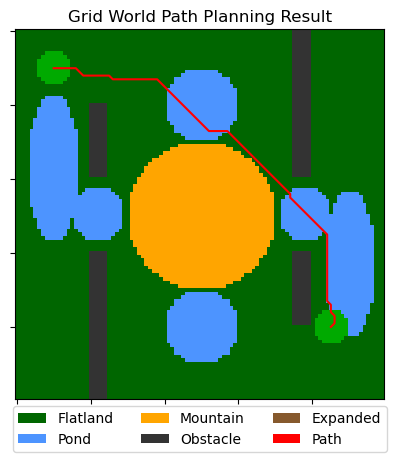

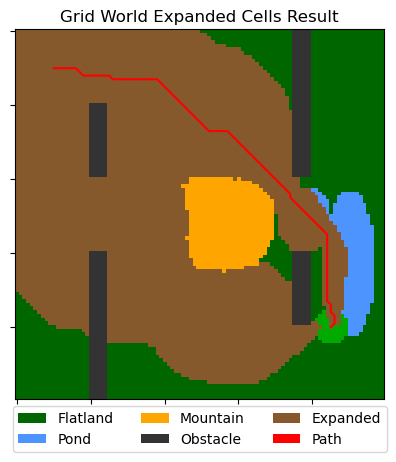

In [11]:
grid = np.load(f"./LPA_Worlds/world_2.npy")
start = (10, 10)
goal = (80, 85)
searcher = LPA_Planner(grid, start, goal)
print("Initial planning...")
main(searcher)

Initial planning...
Path length: 101
Path cost: 87.79036790187179
Number of expanded states: 5827


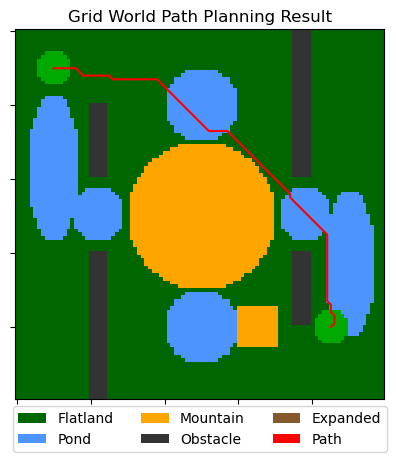

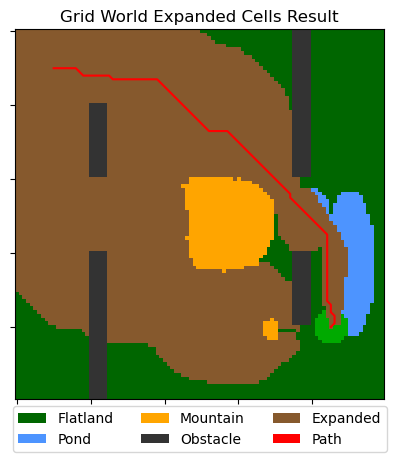

In [12]:
grid = np.load(f"./LPA_Worlds/world_2.npy")
start = (10, 10)
goal = (80, 85)
searcher = LPA_Planner(grid, start, goal)
rows, cols = np.meshgrid(np.arange(75, 86, 1), np.arange(60, 71, 1))
#print(rows)
searcher.update_costs(rows.flatten(), cols.flatten(), Environment.MOUNTAIN)
print("Initial planning...")
main(searcher)

Initial planning...
Path length: 100
Path cost: 80.92640687119282
Number of expanded states: 4762


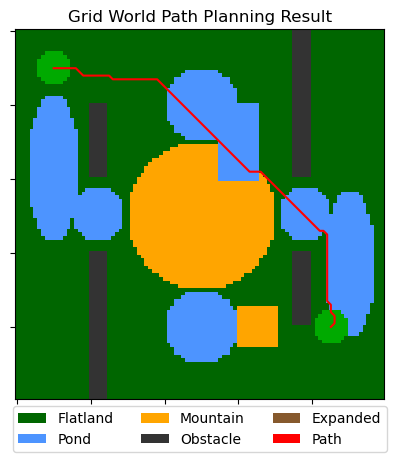

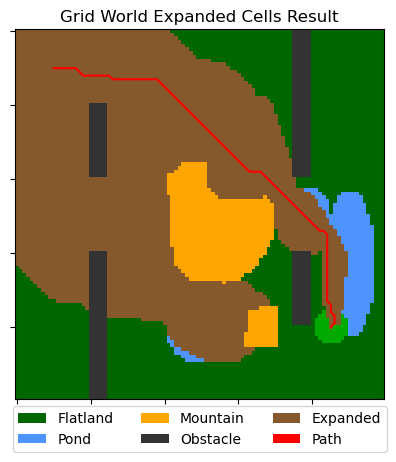

In [13]:
grid = np.load(f"./LPA_Worlds/world_2.npy")
start = (10, 10)
goal = (80, 85)
searcher = LPA_Planner(grid, start, goal)
rows1, cols1 = np.meshgrid(np.arange(75, 86, 1), np.arange(60, 71, 1))
rows2, cols2 = np.meshgrid(np.arange(20, 41, 1), np.arange(55, 66, 1))
searcher.update_costs(rows1.flatten(), cols1.flatten(), Environment.MOUNTAIN)
searcher.update_costs(rows2.flatten(), cols2.flatten(), Environment.POND)
print("Initial planning...")
main(searcher)

# **World 3**

Initial planning...
Path length: 101
Path cost: 125.68124086713173
Number of expanded states: 8516


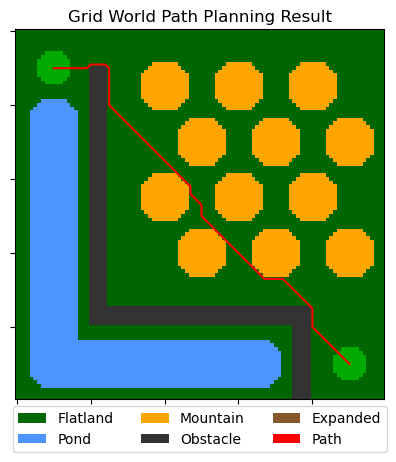

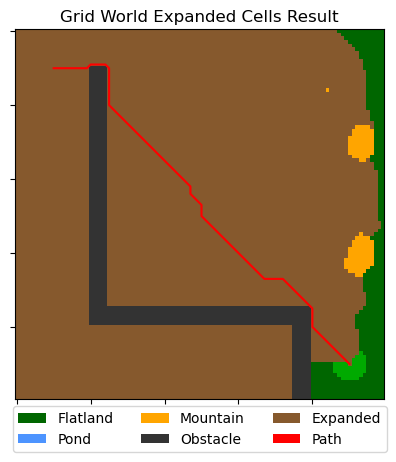

In [14]:
grid = np.load(f"./LPA_Worlds/world_3.npy")
start = (10, 10)
goal = (90, 90)
searcher = LPA_Planner(grid, start, goal)
print("Initial planning...")
main(searcher)

In [ ]:
grid = np.load(f"./LPA_Worlds/world_3.npy")
start = (10, 10)
goal = (80, 85)
searcher = LPA_Planner(grid, start, goal)
print("Initial planning...")
main(searcher)

Initial planning...


Initial planning...
Path length: 101
Path cost: 109.18986283848338
Number of expanded states: 7900


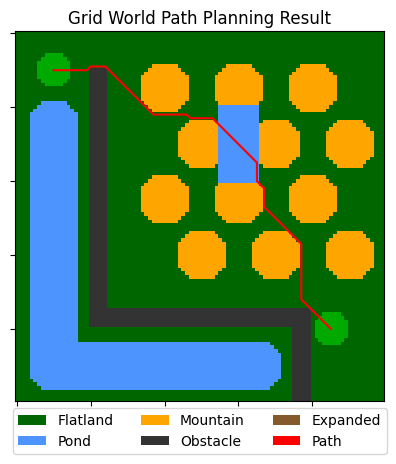

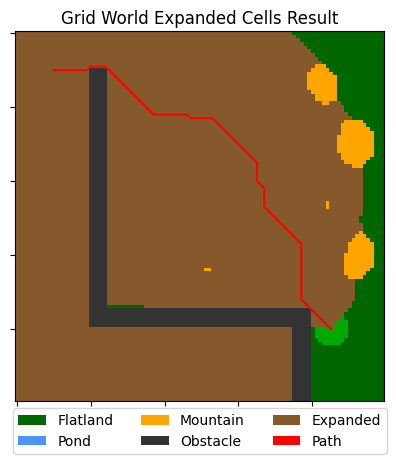

In [37]:
grid = np.load(f"/content/drive/MyDrive/LPA_Worlds/world_3.npy")
start = (10, 10)
goal = (80, 85)
searcher = LPA_Planner(grid, start, goal)
rows2, cols2 = np.meshgrid(np.arange(20, 41, 1), np.arange(55, 66, 1))
searcher.update_costs(rows2.flatten(), cols2.flatten(), Environment.POND)
print("Initial planning...")
main(searcher)